In [8]:
!pip install --upgrade language-check

  Created wheel for language-check: filename=language_check-1.1-cp37-none-any.whl size=56968214 sha256=8ea831d5fa35004f2bea28ce0134c1832e4cd82f4f13442c090b20c3e2f3d510
  Stored in directory: C:\Users\harsh\AppData\Local\pip\Cache\wheels\d5\46\82\90a89c23eac1837364ed7217a9eed71bc9e6ad4825be93968e
Successfully built language-check


In [37]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,_preprocess,TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split

In [38]:
data = pd.read_csv(r'data/medical_data.csv',low_memory=False)

In [39]:
data = data.drop_duplicates().reset_index().drop('index',axis = 1)

In [40]:
data

,Phrase,Prompt
0,When I remember her I feel down,Emotional pain
1,there is too much pain when i move my arm,Heart hurts
2,My son had his lip pierced and it is swollen a...,Infected wound
3,My muscles in my lower back are aching,Infected wound
4,i have muscle pain that my back\nI Have Muscle...,Foot ache
...,...,...
735,There is a feeling of emptiness creeping up to...,emotional pain
736,This weird pain under my chest has been growin...,internal pain
737,It is very hard to concentrate since the last ...,emotional pain
738,Walking to work seems difficult now and there ...,body feels weak


In [41]:
punctuation='["\'?,\.]' # I will replace all these punctuation with ''
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "where's":"where is",
    "where're":"where are",
    "i'm":"i am",
    "we're":"we are",
    "it's":"it is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    "i've":"i have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",
    "i'll":"i will",
    "it'll":"it will",
    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

In [42]:
def process_data(data):
    # Convert to lower case
    
    data.Phrase=data.Phrase.str.lower() 
    data.Prompt=data.Prompt.str.lower()
    # convert to string 
    data.Phrase=data.Phrase.astype(str)
    data.Prompt=data.Prompt.astype(str)
    # replace abbreviations 
    data.replace(abbr_dict,regex=True,inplace=True)
    
    #apply stemming
    stemmer = SnowballStemmer("english")
    data['stemmed_phrase'] = data['Phrase'].apply(lambda x : ' '.join([stemmer.stem(y) for y in x.split()]))
    display(data.head(10))
    return data

In [43]:
data = process_data(data)

,Phrase,Prompt,stemmed_phrase
0,when i remember her i feel down,emotional pain,when i rememb her i feel down
1,there is too much pain when i move my arm,heart hurts,there is too much pain when i move my arm
2,my son had his lip pierced and it is swollen a...,infected wound,my son had his lip pierc and it is swollen and...
3,my muscles in my lower back are aching,infected wound,my muscl in my lower back are ach
4,i have muscle pain that my back i have muscle ...,foot ache,i have muscl pain that my back i have muscl pa...
5,i have muscle pain in my left leg,shoulder pain,i have muscl pain in my left leg
6,i have cut my finger because of playing footba...,injury from sports,i have cut my finger becaus of play footbal an...
7,i have acne in my face and other problems in m...,skin issue,i have acn in my face and other problem in my ...
8,i have a strange rash on my arm,foot ache,i have a strang rash on my arm
9,i have a sharp pain in my lower stomach,stomach ache,i have a sharp pain in my lower stomach


In [44]:
d2 = data[['stemmed_phrase','Prompt']]

In [46]:
d2.to_csv('data/trial_data.csv')

In [8]:
ailments = data['Prompt'].unique()

In [9]:
dict_ail = {}
# for a in ailments:
#     dict_ail[a] = 0
for k in data.index:
    name = data['Prompt'][k]
    dict_ail[name] = dict_ail.get(name,0) + 1
ailment_dict = {}

for i,k in enumerate(dict_ail.keys()):
    ailment_dict[i] = k

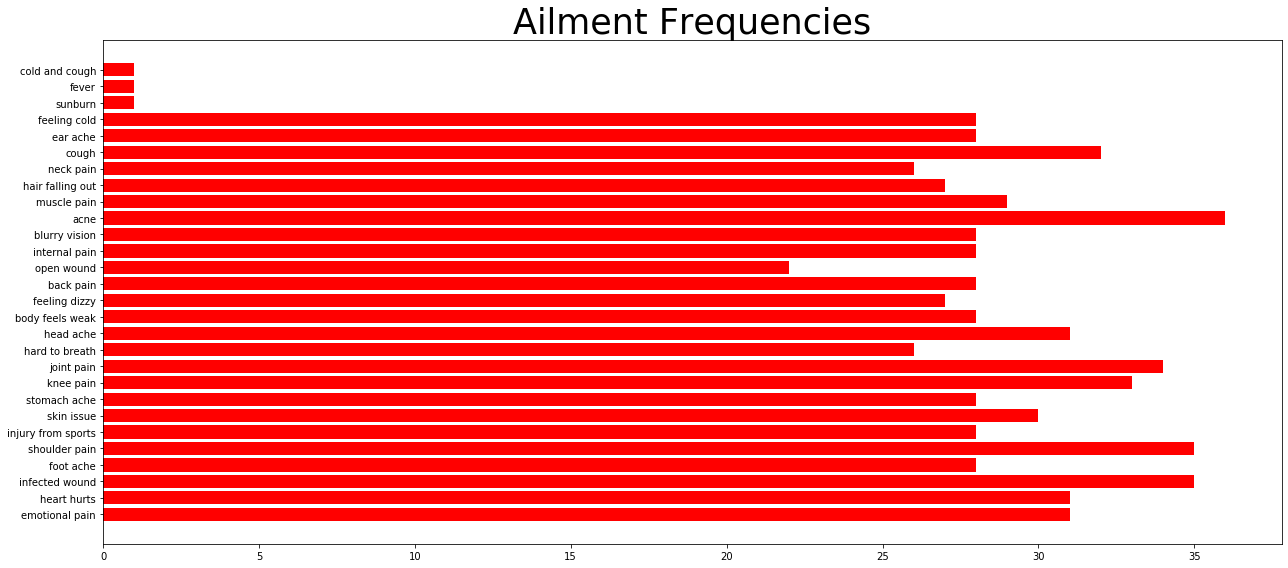

In [10]:
plt.figure(figsize = (18,8))
plt.title("Ailment Frequencies",fontsize=35)
plt.barh(color = 'Red',y=[i for i in range(len(list(ailments)))], width = list(dict_ail.values()),tick_label = list(dict_ail.keys()))
plt.tight_layout()

In [11]:
Cv = CountVectorizer(stop_words='english',ngram_range = (1,3), max_df=0.7)
transformed_count = Cv.fit_transform(data['stemmed_phrase']) 

In [12]:
TfIdf = TfidfVectorizer(stop_words = 'english', ngram_range= (1,3),max_df= 0.7)
transformed_idf = TfIdf.fit_transform(data['stemmed_phrase'])

In [33]:
input_text = ['I am experiencing pain in the leg from the past two days']
trial = TfIdf.transform(input_text)

In [14]:
trial

<1x4970 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

## Flow 
- Get the text input from the patient
- This text input is processed first by the vectorizer and made into a list of frequeny counts using the learned vocabulary from the data provided
- Now this list is passed into a model which generates the probabilities of which ailment does that sentence phrase correspond to 
- The final returned phrases are evaluated and the phrases having the least levenshtein distance are used for predictions
- The two of the highest probability ailments are returned to the doctor with a wrapper sentence

## Output Tensor
- We have a 25 element output vector which is the result from the model

In [21]:
ailment_dict

{0: 'emotional pain',
 1: 'heart hurts',
 2: 'infected wound',
 3: 'foot ache',
 4: 'shoulder pain',
 5: 'injury from sports',
 6: 'skin issue',
 7: 'stomach ache',
 8: 'knee pain',
 9: 'joint pain',
 10: 'hard to breath',
 11: 'head ache',
 12: 'body feels weak',
 13: 'feeling dizzy',
 14: 'back pain',
 15: 'open wound',
 16: 'internal pain',
 17: 'blurry vision',
 18: 'acne',
 19: 'muscle pain',
 20: 'hair falling out',
 21: 'neck pain',
 22: 'cough',
 23: 'ear ache',
 24: 'feeling cold',
 25: 'sunburn',
 26: 'fever',
 27: 'cold and cough'}

## Input Tensor

In [3]:
# the query is first processed and made into lower case 
query = "From past few weeks feeling sad"

In [4]:
def process_query(query):
    # Change to lower
    query = query.lower()
    # Removed abbreviations
    res = ''
#     print(query.split())
    for k in query.split():
        if k in abbr_dict:
            print(abbr_dict[k])
            res+=' ' + abbr_dict[k]
        else:
            res+=' ' + k 
    
    stemmer = SnowballStemmer('english')
    res = ' '.join([stemmer.stem(y) for y in res.split()])
    return res 

In [5]:
print("Example query: ")
print("Final query:",process_query(query))
processed = process_query(query)

Example query: 


NameError: name 'abbr_dict' is not defined

In [25]:
query =[processed]
res = TfIdf.transform(query)
sim = cosine_similarity(res,transformed_idf)
res = list(np.argsort(sim))[0]
res = res[::-1][:3]

In [26]:
for k in res:
    print(data.loc[k]['Prompt'])

emotional pain
emotional pain
skin issue


In [142]:
def get_prediction(query):
    print("Query is :",query)
    processed = process_query(query)
    query = [processed]
    print("Processed :",query)
    res = TfIdf.transform(query)
    sim = cosine_similarity(res,transformed_idf)   
    res = list(np.argsort(sim))[0]
    res = res[::-1][:20]
    print(sim[0][res[0]],sim[0][res[1]])
    ailment =[]
    # let's find most similar sentences and then see 
    # use levenshtein distance after you have got the result
    for k in res[:1]:
        ailment.append(data.loc[k]['Prompt'])
    print("Results :")
    return ailment

## To - Do
- Use document distance after you find the sentences to evaluate the best possible match for your query


In [143]:
for q in data['stemmed_phrase'][500:]:
    print(get_prediction(q))

Query is : my stomach feel full and upset and bloat after big meal
Processed : ['my stomach feel full and upset and bloat after big meal']
1.0000000000000002 0.15631720706831426
Results :
['stomach ache']
Query is : my mind feel veri sad as if it hurt the way i feel in my head is aw and when i think about my break-up i cri with sad
Processed : ['my mind feel veri sad as if it hurt the way i feel in my head is aw and when i think about my break-up i cri with sad']
1.0000000000000002 0.30769684560534594
Results :
['emotional pain']
Query is : i have a head pain everi singl day
Processed : ['i have a head pain everi singl day']
1.0000000000000002 0.19773183226222532
Results :
['internal pain']
Query is : my heart feel like it is go to explod
Processed : ['my heart feel like it is go to explod']
1.0000000000000002 0.26650915481854837
Results :
['heart hurts']
Query is : my shoulder hurt when i tri to reach someth abov my head
Processed : ['my shoulder hurt when i tri to reach someth abov m

1.0 0.14737441192870276
Results :
['body feels weak']
Query is : when i stand up too quick i feel as though i am go to faint
Processed : ['when i stand up too quick i feel as though i am go to faint']
1.0000000000000002 0.2817086353909961
Results :
['feeling dizzy']
Query is : i must see a doctor i have an open wound
Processed : ['i must see a doctor i have an open wound']
1.0 0.38623162411030987
Results :
['open wound']
Query is : the pain in my back dwwls like a sharp knife in it
Processed : ['the pain in my back dwwls like a sharp knife in it']
1.0000000000000002 0.1066795354522889
Results :
['back pain']
Query is : i can hard move my neck it hurt
Processed : ['i can hard move my neck it hurt']
1.0 0.35857521154689637
Results :
['neck pain']
Query is : i feel a bone-on-bon pain in my knee when i climb stair
Processed : ['i feel a bone-on-bon pain in my knee when i climb stair']
1.0 0.609978161635433
Results :
['joint pain']
Query is : when i walk it is hard to breath
Processed : ['w

1.0 0.2974101051898479
Results :
['hair falling out']
Query is : i have a great stomach ach and i can not eat ani thing
Processed : ['i have a great stomach ach and i can not eat ani thing']
1.0 0.3086890430014834
Results :
['stomach ache']
Query is : i cannot breath becaus of this dull ach below my left shoulder
Processed : ['i cannot breath becaus of this dull ach below my left shoulder']
1.0000000000000002 0.26482767827534764
Results :
['heart hurts']
Query is : i have a dull ach in my stomach it get wors after i eat
Processed : ['i have a dull ach in my stomach it get wor after i eat']
0.7029572449606246 0.408758261199047
Results :
['internal pain']
Query is : i have shoot pain up and down my back
Processed : ['i have shoot pain up and down my back']
1.0000000000000002 0.6165549295116654
Results :
['back pain']
Query is : my hair is fall out in bunch
Processed : ['my hair is fall out in bunch']
1.0 0.5603956501099638
Results :
['hair falling out']
Query is : i have a cut that is re

1.0 0.27523596420340685
Results :
['hair falling out']
Query is : this long scar on my left buttock is from fall off my mountain bike
Processed : ['this long scar on my left buttock is from fall off my mountain bike']
1.0 0.09818416842570081
Results :
['injury from sports']
Query is : i feel like i just can not cope anymor i feel overwhelm and like i just can not get a break
Processed : ['i feel like i just can not cope anymor i feel overwhelm and like i just can not get a break']
1.0000000000000002 0.12681214549227426
Results :
['emotional pain']
Query is : i feel chilli like an ice cube my sister said that she need sever blanket to cover her so that she is warm enough
Processed : ['i feel chilli like an ice cube my sister said that she need sever blanket to cover her so that she is warm enough']
1.0 0.06961643764844953
Results :
['feeling cold']
Query is : i carri a heavi bag yesterday and when i get up today i felt a great shoulder pain
Processed : ['i carri a heavi bag yesterday an

## Use random forest

In [34]:
model = RandomForestClassifier(n_estimators=100,min_samples_leaf=2,bootstrap=True)

## Generate Data first
- First make a transformed matrix and associate each of the sentences with a numeric row and each prompt with a numeric dictionary value

In [53]:
data[:3]

,Phrase,Prompt,stemmed_phrase
0,when i remember her i feel down,emotional pain,when i rememb her i feel down
1,there is too much pain when i move my arm,heart hurts,there is too much pain when i move my arm
2,my son had his lip pierced and it is swollen a...,infected wound,my son had his lip pierc and it is swollen and...


In [13]:
TfIdf = TfidfVectorizer(stop_words = 'english', ngram_range= (1,3),max_df= 0.7)
X = TfIdf.fit_transform(data['stemmed_phrase']).toarray()

## Generate the Y 
- Generate the class data 

In [14]:
ailment_dict

{0: 'emotional pain',
 1: 'heart hurts',
 2: 'infected wound',
 3: 'foot ache',
 4: 'shoulder pain',
 5: 'injury from sports',
 6: 'skin issue',
 7: 'stomach ache',
 8: 'knee pain',
 9: 'joint pain',
 10: 'hard to breath',
 11: 'head ache',
 12: 'body feels weak',
 13: 'feeling dizzy',
 14: 'back pain',
 15: 'open wound',
 16: 'internal pain',
 17: 'blurry vision',
 18: 'acne',
 19: 'muscle pain',
 20: 'hair falling out',
 21: 'neck pain',
 22: 'cough',
 23: 'ear ache',
 24: 'feeling cold',
 25: 'sunburn',
 26: 'fever',
 27: 'cold and cough'}

In [15]:
# ailment_dict
ailment = {}
for i,j in ailment_dict.items():
    ailment[j] = i
print(ailment)
Y = data['Prompt'].map(ailment)

{'emotional pain': 0, 'heart hurts': 1, 'infected wound': 2, 'foot ache': 3, 'shoulder pain': 4, 'injury from sports': 5, 'skin issue': 6, 'stomach ache': 7, 'knee pain': 8, 'joint pain': 9, 'hard to breath': 10, 'head ache': 11, 'body feels weak': 12, 'feeling dizzy': 13, 'back pain': 14, 'open wound': 15, 'internal pain': 16, 'blurry vision': 17, 'acne': 18, 'muscle pain': 19, 'hair falling out': 20, 'neck pain': 21, 'cough': 22, 'ear ache': 23, 'feeling cold': 24, 'sunburn': 25, 'fever': 26, 'cold and cough': 27}


In [16]:
Y

0       0
1       1
2       2
3       2
4       3
       ..
735     0
736    16
737     0
738    12
739    11
Name: Prompt, Length: 740, dtype: int64

## Got X and Y 
- Split in training and validation sets

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 43, shuffle = True)

In [88]:
model.fit(X_train,Y_train)

RandomForestClassifier(min_samples_leaf=2)

In [58]:
y_preds = model.predict(X_test)

In [59]:
correct,incorrect =0,0
for k,i in zip(y_preds,Y_test):
    if(k==i):
        correct+=1
    else:
        incorrect+=1

In [60]:
correct

104

In [61]:
incorrect

44

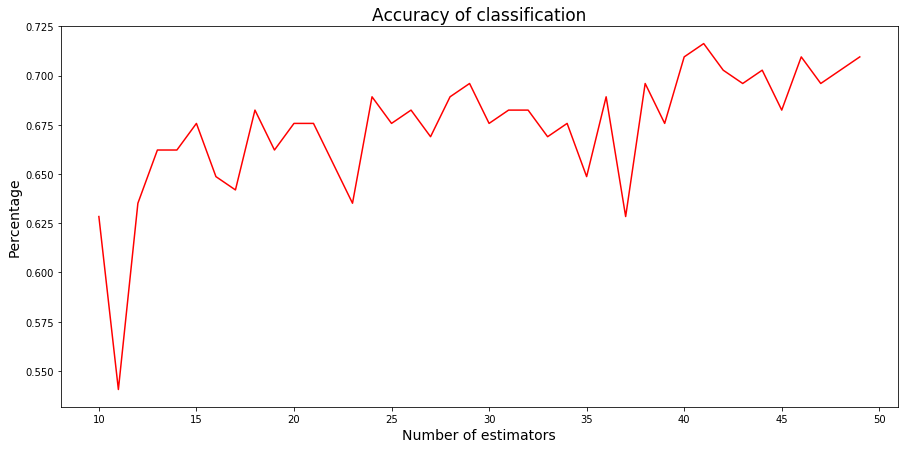

In [75]:
score =[]
for est in range(10,50):
    model = RandomForestClassifier(n_estimators=est,min_samples_leaf=2)
    model.fit(X_train,Y_train)  
    s = model.score(X_test,Y_test)
    score.append(s)
plt.figure(figsize= (15,7))
plt.title("Accuracy of classification",fontsize=17)
plt.xlabel("Number of estimators",fontsize = 14)
plt.ylabel("Percentage",fontsize = 14)
plt.plot([i for i in range(10,50)],score,color= 'red')

## Now
- Whenever you get a query, you need to transform it according to your vocabulary and then predict the class and then return the predicted class from model 

In [42]:
def process_query(query):
    # Change to lower
    query = query.lower()
    # Removed abbreviations
    res = ''
#     print(query.split())
    for k in query.split():
        if k in abbr_dict:
            print(abbr_dict[k])
            res+=' ' + abbr_dict[k]
        else:
            res+=' ' + k 
    
    stemmer = SnowballStemmer('english')
    res = ' '.join([stemmer.stem(y) for y in res.split()])
    return res 

In [44]:
# suppose I have the best model 
model = RandomForestClassifier(n_estimators=33,min_samples_leaf=2,bootstrap=True,max_features=300)
model.fit(X_train,Y_train)
for i,j in zip(X_test,Y_test):
    query = data.iloc['Phrase'][i]
    print("Query :",query)
    print("Original :",ailment_dict[j])
    query = process_query(query)
    query = [query]
    #now transform the document according to the vectorizer 
    query = TfIdf.transform(query)
    # now predict it 
    pred = model.predict_proba(query)
    res = list(np.argsort(pred))[0]
    res = res[::-1][:3]
    for k in res:
        print(ailment_dict[k],end=',')
    print()

Query : you will not believ me but this infect wound on my hand is from a paper cut i did not take serious
Original : infected wound
infected wound,open wound,skin issue,
Query : these red spot on my cheek are new what is it
Original : skin issue
skin issue,infected wound,acne,
Query : i have a skin rash after eat an ice-cream
Original : skin issue
skin issue,open wound,muscle pain,
Query : i have a sharp pain in my abdomen
Original : internal pain
internal pain,muscle pain,back pain,
Query : i feel a strang and power pain insid my rib cage
Original : heart hurts
internal pain,heart hurts,back pain,
Query : use hair tonic
Original : hair falling out
hair falling out,acne,blurry vision,
Query : this long scar on my left buttock is from fall off my mountain bike
Original : injury from sports
hair falling out,internal pain,heart hurts,
Query : i feel like i just can not cope anymor i feel overwhelm and like i just can not get a break
Original : emotional pain
emotional pain,feeling dizzy,

## KNN

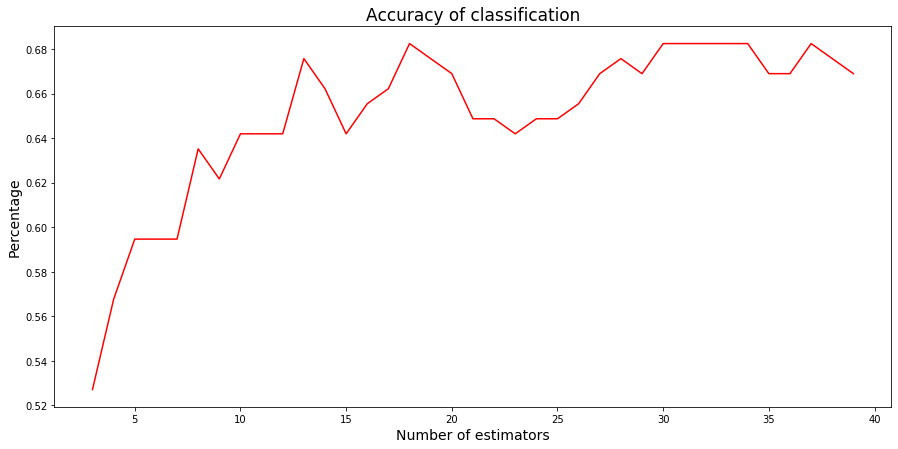

In [25]:
score =[]
for est in range(3,40):
    model = KNeighborsClassifier(n_neighbors=est,metric='minkowski')
    model.fit(X_train,Y_train)  
    s = model.score(X_test,Y_test)
    score.append(s)
plt.figure(figsize= (15,7))
plt.title("Accuracy of classification",fontsize=17)
plt.xlabel("Number of estimators",fontsize = 14)
plt.ylabel("Percentage",fontsize = 14)
plt.plot([i for i in range(3,40)],score,color= 'red')

In [34]:
p = pd.DataFrame([[1,2],[2,3]],columns=['a','b'])

In [19]:
p

,a,b
0,1,2
1,2,3


In [35]:
p = p.append([{'a':1,'b':23}],ignore_index=True)

In [36]:
p.append([{'a':1,'b':2223}],ignore_index=True)

,a,b
0,1,2
1,2,3
2,1,23
3,1,2223
